In [1]:
import cdsapi
import os
import ssl
import warnings
from pathlib import Path
from tqdm import tqdm
import netCDF4
from netCDF4 import num2date
import zipfile
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
import geopandas as gpd
import sys
import rasterio as rio
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
from datetime import datetime, timedelta

# Suppress all warnings
warnings.filterwarnings("ignore")


from sqlalchemy import create_engine, text

# Append the pyquacache path
sys.path.append(str(Path().resolve().parent))
import pyquacache.utils.queries as pqc
from pyquacache.defs.config import db_url_prod as db_url



# Download drainage basin boundaries
gdf = pqc.fetch_drainage_basin_boundaries()


data_dir = Path(".data")



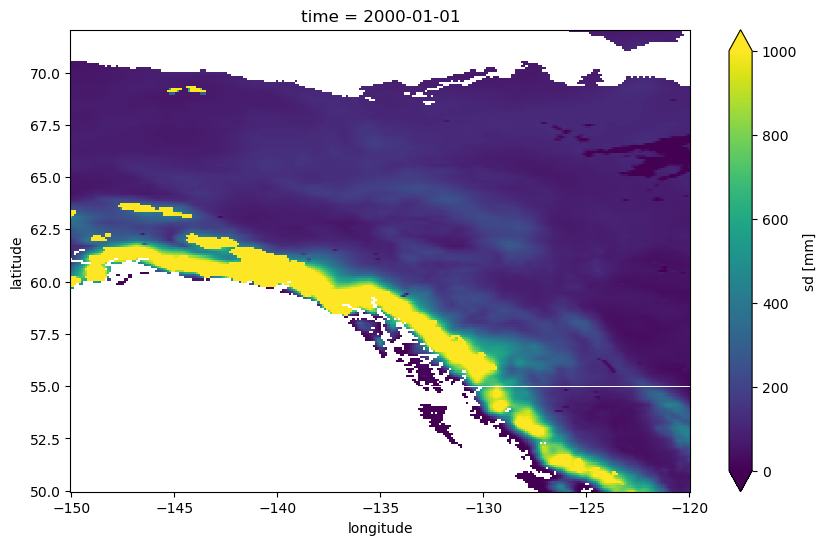

In [2]:
import era5utils as era5

"""
era5.download_from_cds(
    years=[2024, 2025]
)
era5.zip_to_nc(source_dir=data_dir/"raw", destination_dir=data_dir/"extracted")
"""

xda = era5.concatenate_to_xda(
    data_dir/"extracted",
    param="sd", 
    freq=None,
    resampling_function="mean"
    )

xda.sel(time=xda.time[0].values).plot(cmap="viridis", add_colorbar=True, figsize=(10, 6), vmin=0, vmax=1000)

In [ ]:

# resample to monthly
xda_monthly = xda.resample(time="1M").mean()

# by default, monthly means are taken at the end of the month, so we need to shift them to the start of the month
xda_monthly["time"] = pd.to_datetime(xda_monthly["time"].values) + pd.DateOffset(days=1)

historic_monthly_mean = xda_monthly.groupby("time.month").mean(dim="time", skipna=True)
#historic_monthly_max = xda_monthly.groupby("time.month").max(dim="time", skipna=True)
#historic_monthly_min = xda_monthly.groupby("time.month").min(dim="time", skipna=True)
#historic_monthly_std = xda_monthly.groupby("time.month").std(dim="time", skipna=True)
#historic_monthly_med = xda_monthly.groupby("time.month").median(dim="time", skipna=True)

xda_daily = xda.resample(time="1D").mean()
xda_daily["time"] = pd.to_datetime(xda_daily["time"].values, utc=True)
historic_yearly_mean =  xda_monthly.groupby("time.day").mean(dim="time", skipna=True)

#deviation_from_norm = deviation_from_norm.clip(min=-200, max=200)


In [3]:
xda_daily = xda.resample(time="1d").mean()
xda_daily["time"] = pd.to_datetime(xda_daily["time"].values)

start_hist = "2000-01-01"
end_hist = "2020-12-31"
historic_yearly_mean =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").mean(dim="time", skipna=True)
#historic_yearly_med =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").median(dim="time", skipna=True)
#historic_yearly_max =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").max(dim="time", skipna=True)
#historic_yearly_min =  xda_daily.sel(time=slice(start_hist, end_hist)).groupby("time.dayofyear").min(dim="time", skipna=True)


In [4]:
del(xda_daily)

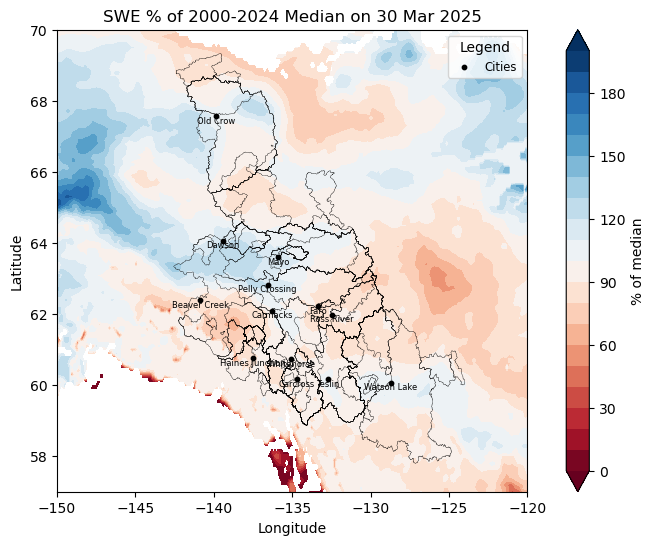

In [5]:
# Example: Convert day of year 100 in the year 2025 to a datetime
year = 20
doy = 89
query_datetime = pd.Timestamp(datetime(2025, 1, 1) + timedelta(days=doy - 1))
historic_data = historic_yearly_mean.sel(dayofyear=doy)
data = xda.sel(time=query_datetime, method="nearest")

deviation_from_norm = 100 * (data) / historic_data


fig, ax = plt.subplots(figsize=(10, 6))

# Create a contour plot for deviation_from_norm
contour = ax.contourf(
    deviation_from_norm.longitude,
    deviation_from_norm.latitude,
    deviation_from_norm.values,
    levels=np.linspace(0, 200, 21),  # Levels centered around 0
    cmap="RdBu",  # Red-White-Blue colormap
    extend='both'
)

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, extend='both')
cbar.set_label(r"% of median")

# Add labels and title
ax.set_title(f"SWE % of 2000-2024 Median on {query_datetime.strftime('%d %b %Y')}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

gdf.plot(ax=ax, color="None", edgecolor="black", label='Locations', linewidth=0.2)

# Add cities to the map
cities = gpd.read_file(".data/shapes/cgn_yt_shp_eng.zip", crs="EPSG:4326")
cities = cities[(cities.CATEGORY == "Populated Place") & (cities.REL_SCALE.astype(int) > 3000000)]
for idx, row in cities.iterrows():
    ax.text(
        row.geometry.x, row.geometry.y, row.GEONAME,
        fontsize=6, color='black', ha='center', va='top'
    )
# Plot cities on the map
cities.plot(ax=ax, color='black', markersize=10, label='Cities')

# Update legend
ax.legend(loc='upper right', fontsize='small', title='Legend')

plt.ylim(57,70)
plt.show()


In [6]:
xda_notz = xda.copy()
xda_notz["time"] = pd.to_datetime(xda_notz["time"].values, utc=False)

def plot_xda_time(time_index):
    """
    Plot the xda data for a specific time index.
    """
    plt.figure(figsize=(10, 6))
    xda_notz.sel(time=xda_notz.time[time_index], method="nearest").plot(cmap="viridis", vmin=0, vmax=500)
    plt.title(f"Snow Depth on {str(xda_notz.time[time_index].values)}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Create an interactive slider
time_slider = IntSlider(min=0, max=len(xda_notz.time) - 1, step=1, value=0, description="Time Index")

# Use the interact function to link the slider to the plot function
interact(plot_xda_time, time_index=time_slider)

interactive(children=(IntSlider(value=0, description='Time Index', max=9225), Output()), _dom_classes=('widget…

<function __main__.plot_xda_time(time_index)>

In [7]:
# get SWE metadata
param_name = "snow water equivalent"
params = pqc.fetch_parameters(db_url)
param_md = params.loc[params["param_name"] == param_name, :]
param_md["unit_default"].values[0]

# get location IDs for SWE timeseries
engine = create_engine(db_url)
with engine.connect() as connection:
    out = connection.execute(
        text(f"SELECT * FROM continuous.timeseries WHERE parameter_id = {param_md.index[0]}")
    )

timeseries_df = pd.DataFrame(out).set_index("timeseries_id")
loc_ids = timeseries_df["location_id"]

# get locations at geodataframe
locations = pqc.fetch_locations(db_url).loc[loc_ids,:]

# download all contniuous SWE measurements
ts_ids = timeseries_df.index.tolist()
res = {}

def fetch_timeseries_corrected(ts_id, db_url=db_url):
    engine = create_engine(db_url)
    with engine.connect() as connection:
        out = connection.execute(
            text("SELECT * FROM continuous.measurements_continuous_corrected WHERE timeseries_id IN ({})".format(ts_id))
        )

        timeseries_md = connection.execute(
            text("SELECT * FROM continuous.timeseries WHERE timeseries_id IN ({})".format(ts_id))
        )
        timeseries_md = pd.DataFrame(timeseries_md).squeeze().to_dict()

        parameter_md = connection.execute(
            text("SELECT * FROM public.parameters WHERE parameter_id IN ({})".format(timeseries_md["parameter_id"]))
        )
        parameter_md = pd.DataFrame(parameter_md).squeeze().to_dict()

        out = pd.DataFrame(out).set_index("datetime")["value_corrected"]
        units = parameter_md["unit_default"]
        param = parameter_md["param_name"]
        tag = f"{ts_id}_{param}({units})"
        out.name = tag
        out = out.astype(float)
        out.to_frame()
        
        metadata = {"timeseries": timeseries_md, "parameter": parameter_md}
        return out, metadata

In [8]:
results = {}

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    x, y = locations.loc[loc_id, "geometry"].x, locations.loc[loc_id, "geometry"].y

    era5_ts = xda.sel(longitude=x, latitude=y, method="nearest").to_dataframe().reset_index()
    era5_ts = era5_ts.set_index('time')['sd']

    yg_ts, _ = fetch_timeseries_corrected(ts_id)
    

    # aggregate to daily before syncing
    yg_ts = yg_ts.resample('D').mean().tz_localize(None)
    era5_ts = era5_ts.resample('D').mean()

    synced_ts = pd.concat([era5_ts, yg_ts], axis=1, join="outer")
    synced_ts.columns = ["ERA5", "YG"]

    results[ts_id] = synced_ts


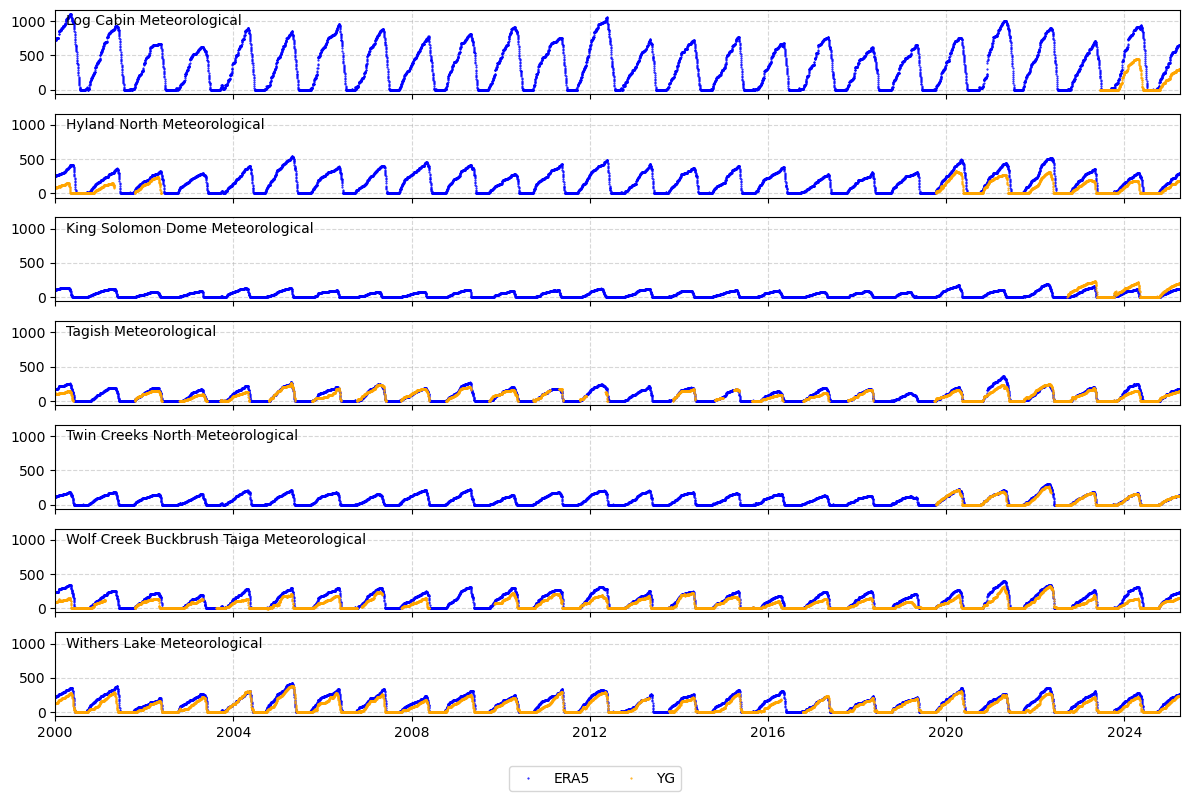

In [11]:
fig, axes = plt.subplots(7, 1, figsize=(12, 8), sharex=True, sharey=True)

axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, ts_id in enumerate(ts_ids):
    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    ax = axes[i]
    synced_ts = results[ts_id]
    ax.plot(synced_ts.index, synced_ts["ERA5"], label="ERA5", color="blue", marker='.', markersize=1, linestyle='', linewidth=0.5)
    ax.plot(synced_ts.index, synced_ts["YG"], label="YG", color="orange", marker='.', markersize=1, linestyle='', linewidth=0.5)

    # Add location annotation
    ax.text(0.01, 0.95, loc_name, transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')

    ax.set_xlim(pd.Timestamp("2000-01-01"), pd.Timestamp("2025-04-01"))
    ax.grid(True, linestyle='--', alpha=0.5)

# Add a single legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Adjust layout to make space for the legend
plt.show()

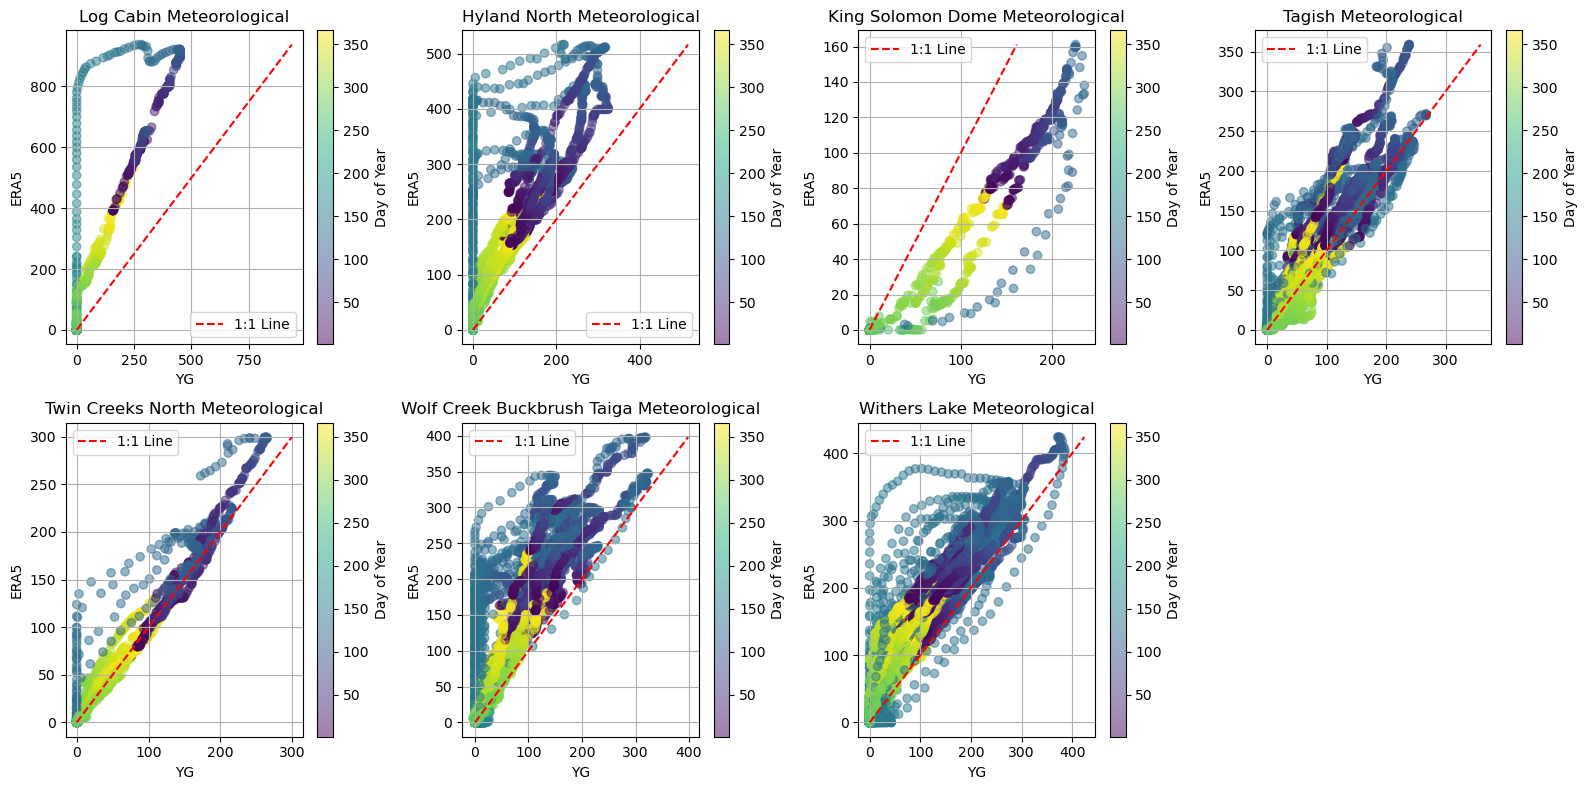

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for ax, (ts_id, data) in zip(axes, results.items()):
    # Drop NaN values for clean comparison
    data = data.dropna()

    loc_id = timeseries_df.loc[ts_id, "location_id"]
    loc_name = locations.loc[loc_id, "name"]

    # Plot 1:1 scatter plot
    scatter = ax.scatter(data["YG"], data["ERA5"], c=data.index.dayofyear, cmap="viridis", alpha=0.5)
    plt.colorbar(scatter, ax=ax, label="Day of Year")
    
    ax.plot([data["ERA5"].min(), data["ERA5"].max()], [data["ERA5"].min(), data["ERA5"].max()], color="red", linestyle="--", label="1:1 Line")

    # Set labels and title
    ax.set_xlabel("YG")
    ax.set_ylabel("ERA5")
    ax.set_title(f"{loc_name}")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for ax in axes[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [30]:

import geopandas as gpd
import importlib
importlib.reload(pqc)

# fetch locations and results from AquaCache
locations_table = pqc.fetch_locations()
results_table = pqc.fetch_table(table_name="discrete.results").set_index("result_id")

# grab the SWE
yg_swe_df = results_table.loc[results_table["parameter_id"] == 21]
del(results_table)

# join results to samples, samples get datetime and location from sample_id
sample_ids = yg_swe_df.sample_id.unique()
samples_table = pqc.fetch_table(table_name="discrete.samples").set_index("sample_id")
yg_swe_df["location_id"] = samples_table.loc[yg_swe_df["sample_id"].values, "location_id"].values
yg_swe_df["datetime"] = samples_table.loc[yg_swe_df["sample_id"].values, "datetime"].values
yg_swe_df["target_datetime"] = samples_table.loc[yg_swe_df["sample_id"].values, "target_datetime"].values
yg_swe_df["datetime"] = yg_swe_df["datetime"]
yg_swe_df["target_datetime"] = yg_swe_df["target_datetime"]
yg_swe_df["geometry"] = locations_table.loc[yg_swe_df["location_id"].values, "geometry"].values

# convert to geodataframe
yg_swe_df = gpd.GeoDataFrame(yg_swe_df)

# add datum values to dataframe
datums_table = pqc.fetch_datums(db_url=db_url)
yg_swe_df["datum"] = datums_table.loc[yg_swe_df["location_id"].values, "conversion_m"].values
yg_swe_df["datum"] = yg_swe_df["datum"].astype(float)
yg_swe_df = yg_swe_df.apply(lambda col: pd.to_numeric(col, errors='ignore') if col.name not in ["datetime","target_datetime"] else col)
comparison_df = yg_swe_df[["datetime", "target_datetime", "location_id", "result", "datum", "geometry"]].copy()
comparison_df.rename(columns={"result": "yg_result"}, inplace=True)

In [ ]:
# for each timestep in the YG survey data, sample the ERA5 data 

comparison_df["era5_result"] = np.nan

for name, row in tqdm(comparison_df.iloc[:,:].iterrows()):
    x, y = row.geometry.x, row.geometry.y
    dt = row.datetime

    res = xda.sel(longitude=x, latitude=y, time = dt, method="nearest")
    
    time_diff = dt - pd.Timestamp(res.time.values)
    time_diff = np.absolute(time_diff.days)

    if time_diff < 3:
        comparison_df.loc[name, "era5_result"] = res.values
    else:
        comparison_df.loc[name, "era5_result"] = np.nan

# Calculate the error (difference between observed and ERA5 results)
comparison_df["error"] = comparison_df["yg_result"].astype(float) - comparison_df["era5_result"].astype(float)

9854it [00:15, 654.99it/s]


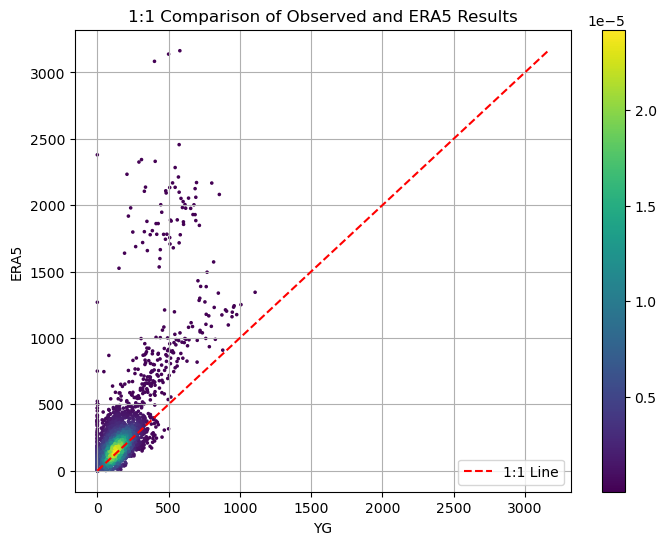

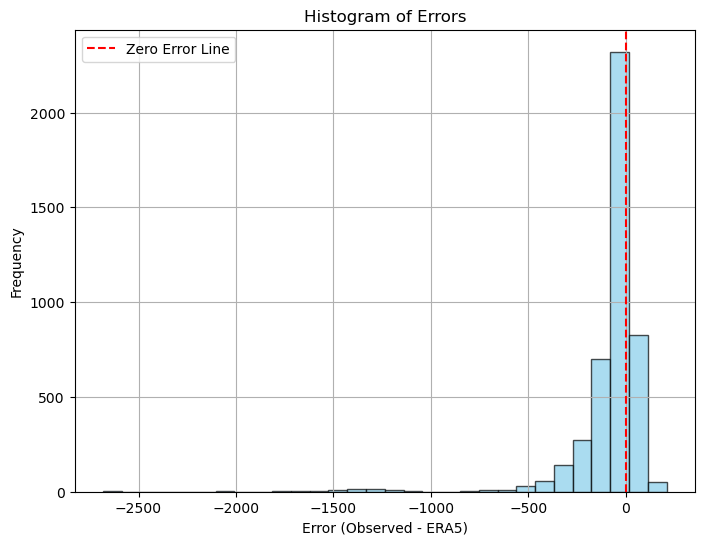

In [33]:
from scipy.stats import gaussian_kde

# Drop rows with NaN values in either 'result' or 'era5_result'
comparison_df = comparison_df.dropna(subset=["yg_result", "era5_result"])
comparison_df["yg_result"] = comparison_df["yg_result"].astype(float)
comparison_df["era5_result"] = comparison_df["era5_result"].astype(float)
# Extract day of year from the datetime column
comparison_df["day_of_year"] = comparison_df["datetime"].dt.dayofyear

# Create the 1:1 scatter plot
plt.figure(figsize=(8, 6))


# Scatter plot with colorized markers based on day of year
# Calculate the point density
xy = np.vstack([comparison_df["yg_result"], comparison_df["era5_result"]])
z = gaussian_kde(xy)(xy)

# Scatter plot with colorized markers based on density
scatter = plt.scatter(
    comparison_df["yg_result"],
    comparison_df["era5_result"],
    c=z,
    cmap="viridis",
    marker='.',
    s=10  # Marker size
)


# Add a colorbar
cbar = plt.colorbar(scatter)

# Add a 1:1 line
min_val = min(comparison_df["yg_result"].min(), comparison_df["era5_result"].min())
max_val = max(comparison_df["yg_result"].max(), comparison_df["era5_result"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="1:1 Line")

# Set plot labels and title
plt.xlabel("YG")
plt.ylabel("ERA5")
plt.title("1:1 Comparison of Observed and ERA5 Results")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Plot the histogram of errors
plt.figure(figsize=(8, 6))
plt.hist(comparison_df["error"], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(0, color="red", linestyle="--", label="Zero Error Line")

# Set plot labels and title
plt.xlabel("Error (Observed - ERA5)")
plt.ylabel("Frequency")
plt.title("Histogram of Errors")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

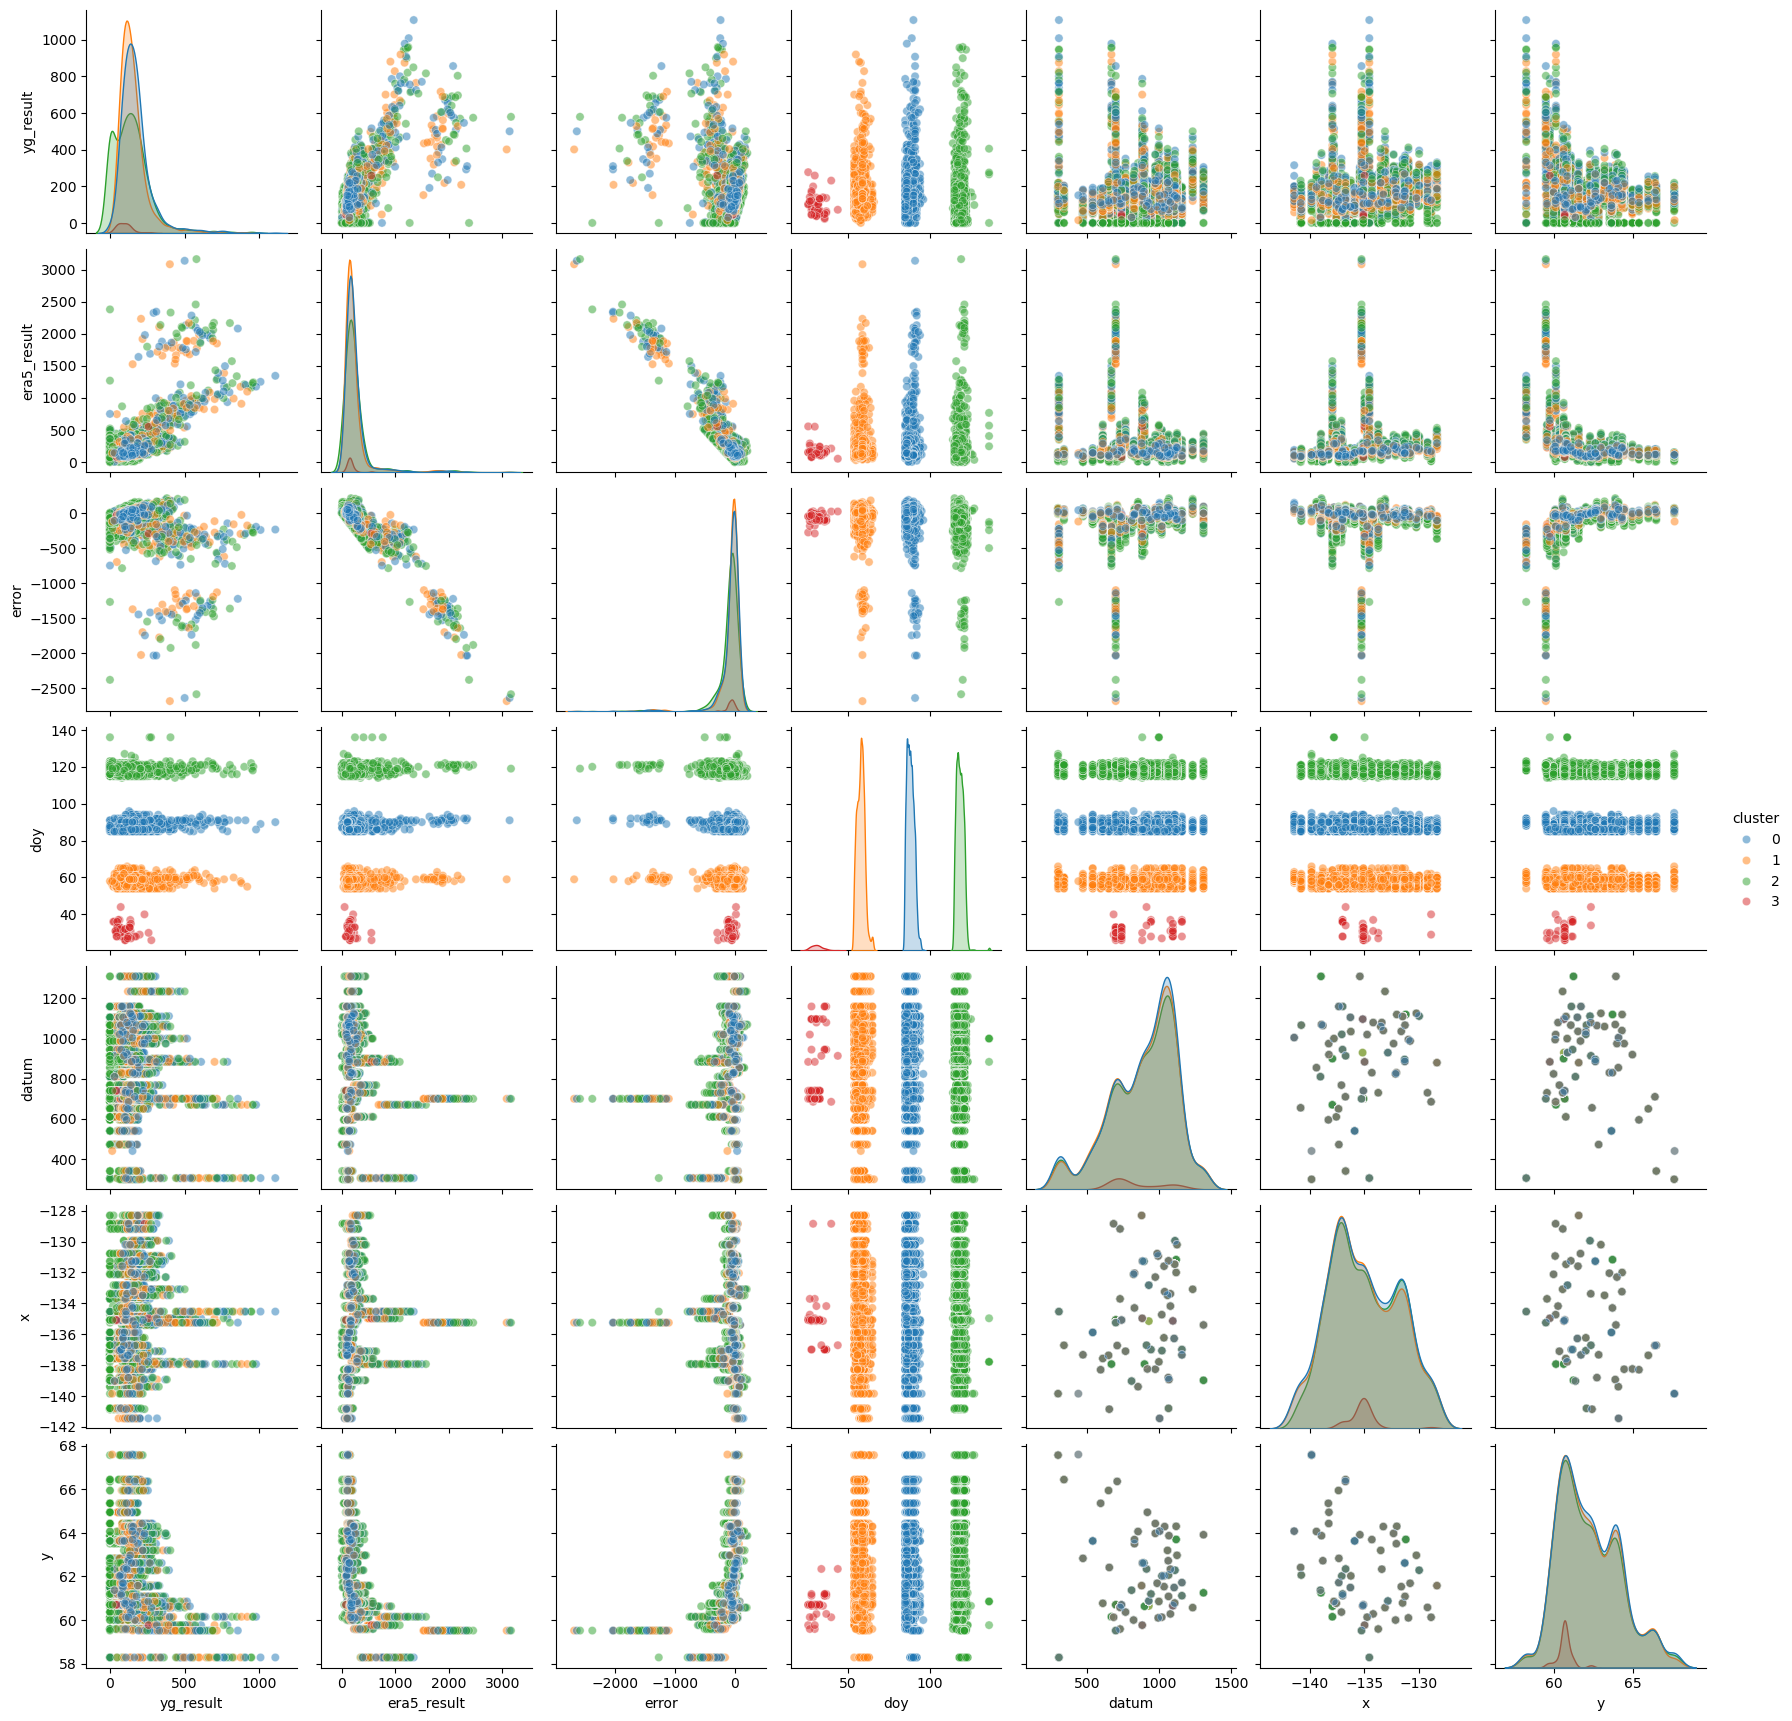

In [46]:
import seaborn as sns
from sklearn.cluster import KMeans
comparison_df["x"] = comparison_df.geometry.x
comparison_df["y"] = comparison_df.geometry.y
comparison_df["doy"] = comparison_df.datetime.dt.dayofyear

# Select numeric columns for the scatterplot matrix
include_columns = ["yg_result","era5_result","error","doy","datum","x","y"]

# Perform KMeans clustering on the 'doy' column
kmeans = KMeans(n_clusters=4, random_state=1)
comparison_df['cluster'] = kmeans.fit_predict(comparison_df[['doy']])

# Create a scatterplot matrix with hue set to the cluster
sns.pairplot(comparison_df[include_columns + ['cluster']], diag_kind='kde', hue='cluster', plot_kws={'alpha': 0.5}, palette="tab10")

# Show the plot
plt.show()


In [ ]:
# load and preprocess the snowcourse factors
from pyquacache.utils.spatialutils import poly_to_mask
snowcourse_factors = pd.read_csv(r"C:\Users\esniede\Documents\github\YGwater\data-raw\snowcourse_factors.csv", index_col=1)
snowcourse_factors = snowcourse_factors[snowcourse_factors.index != "10AD-SC01"] # remove duplicate hyland river vaue
snowcourse_factors.drop(columns=["location_name"], inplace=True)

locations = pqc.fetch_locations(db_url)

# load swe basins
swe_basins = gpd.read_file(".data/shapes/swe_basins_ExportFeatures.zip").set_index("SWE_Basin")
swe_basins = swe_basins.to_crs("EPSG:4326")
# rename factors based on location ID
renaming_dict = {row["location"]:name for name, row in locations.iterrows()}
snowcourse_factors.index = snowcourse_factors.index.map(renaming_dict)

# get the complete list of snow survey dates based on the (corrected) snow survey data
snow_survey_dates = comparison_df["target_datetime"].unique()


In [ ]:
# get the basin-averaged ERA5 SWE
basin_avgs = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)

# also calculate some statistics (ideally this should be done in an xr-da but this will do)
basin_avgs_era5 = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)
basin_avgs_era5_min = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)
basin_avgs_era5_max = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)
basin_avgs_era5_med = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)
basin_distr_era5 = pd.DataFrame(index=snow_survey_dates, columns=snowcourse_factors.columns)
masks = poly_to_mask(reference_data=xda, poly=swe_basins)


for survey_date in snow_survey_dates:
    
    # copy the weights matrix; we're going to adjust the
    snowcourse_factors_corrected = snowcourse_factors.copy()
    idx = survey_date == comparison_df["target_datetime"]
    df = comparison_df.loc[idx,:]

    # get the locations of results available at the survey date
    location_codes = locations.loc[df["location_id"].values, "location"].values
    
    values = []

    # for each sampling location
    for loc, _ in snowcourse_factors_corrected.iterrows():
        idx = df["location_id"] == loc
        # if there are no results for the location, set the value to NaN
        if sum(idx) == 0:
            values.append(np.nan)

        # in the case where there are multiple results for the same location, take the mean of the results
        elif sum(idx) > 0:
            value = df.loc[idx, "yg_result"].mean()
            values.append(value.mean())

    # add dim for matrix multiplication
    values = np.array(values).reshape(-1, 1)
    # set snowcourse factors to 0 if no value is available
    snowcourse_factors_corrected.loc[np.isnan(values).squeeze(),:] = 0
    # normalize for convex combination
    snowcourse_factors_corrected = snowcourse_factors_corrected.div(snowcourse_factors_corrected.sum(axis=0), axis=1)

    # Handle NaNs in values before matrix multiplication (these have a weight of 0, so the values don't matter, just can't be nan for matrix multiplication)
    values[np.isnan(values)] = 0

    # matrix multiplication and store the result in basin_avgs
    basin_avg = snowcourse_factors_corrected.T @ values
    basin_avgs.loc[survey_date, :] = basin_avg.squeeze()

    
    # remove UTC from survey date and convert to day
    #snow_survey_day = snow_survey_dates.tz_localize(None).normalize()

    # get the basin average for the ERA5 data
    for loc in snowcourse_factors.columns:
        # get the mask for the location
        mask = masks[loc]
        # get the ERA5 data for the survey date
        # calculate the basin average using the mask
        basin_avgs_era5.loc[survey_date, loc] = xda.sel(time=survey_date, method="nearest").where(mask).mean()

        x = xda.sel(time=survey_date, method="nearest").where(mask).values.flatten()
        x = x[~np.isnan(x)]
        
        basin_avgs_era5_min.loc[survey_date, loc] = np.percentile(x, 10)
        basin_avgs_era5_max.loc[survey_date, loc] = np.percentile(x, 90)
        basin_avgs_era5_med.loc[survey_date, loc] = xda.sel(time=survey_date, method="nearest").where(mask).median()



        basin_distr_era5.at[survey_date, loc] = x


basin_avgs = basin_avgs.astype(float)
basin_avgs_era5 = basin_avgs_era5.astype(float)
basin_avgs_era5_min = basin_avgs_era5_min.astype(float)
basin_avgs_era5_max = basin_avgs_era5_max.astype(float)
basin_avgs_era5_med = basin_avgs_era5_med.astype(float)

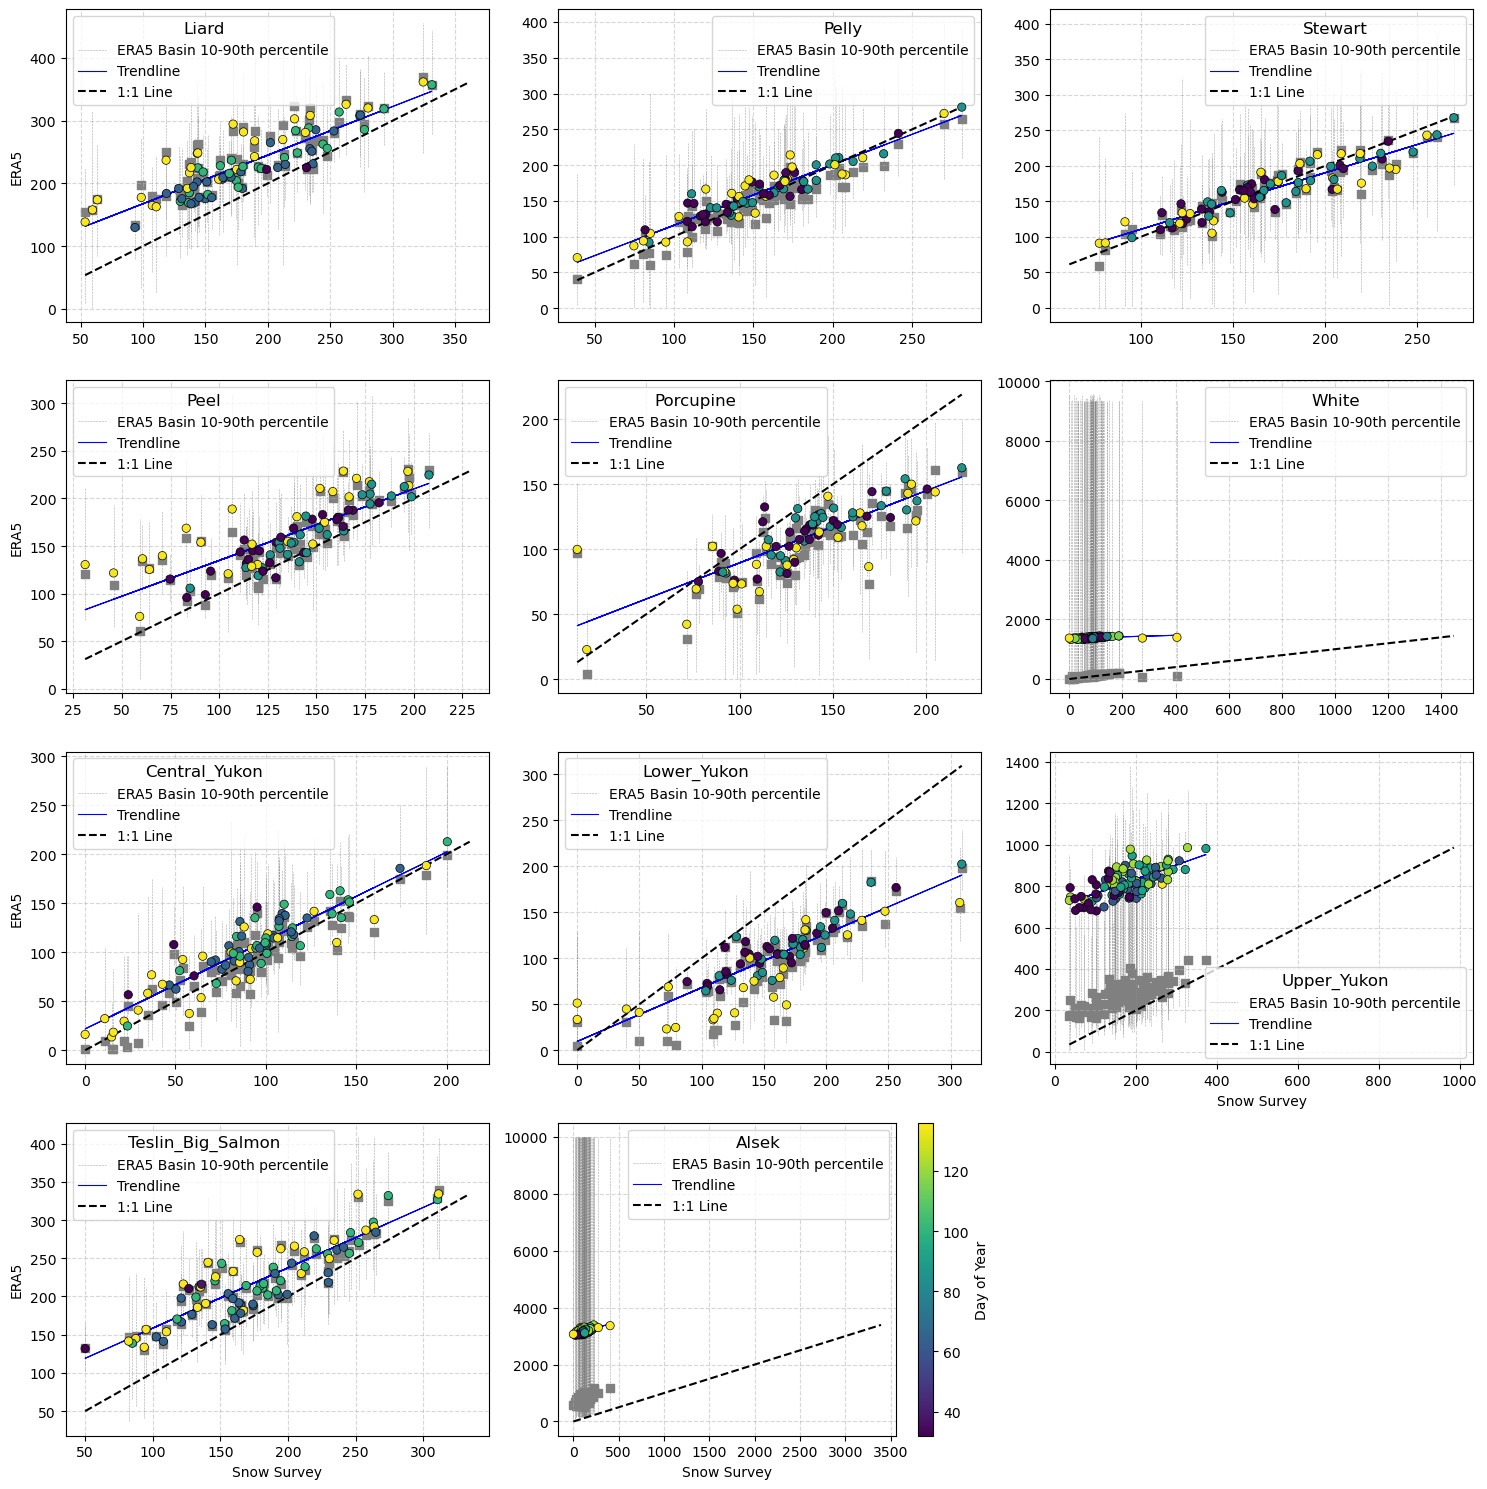

In [ ]:
# Plot the ERA5 basin averages versus the YG basin averages (calculated using the snowcourse factors)

colors = plt.cm.Paired.colors  # Use the 'jet' colormap for different colors
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))  # Adjust rows and columns as needed
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, basin in enumerate(basin_avgs.columns):
    ax = axes[i]

    ax.vlines(
        x=basin_avgs[basin],
        ymin=basin_avgs_era5_min[basin],
        ymax=basin_avgs_era5_max[basin],
        color="grey",
        linestyle="--",
        alpha=0.7,
        label="ERA5 Basin 10-90th percentile",
        linewidth=0.4
    )

    ax.scatter(basin_avgs[basin], basin_avgs_era5_med[basin], color="grey", marker='s', label="ERA5 basin median")
    
    # Scatter plot with markers colored by day of year
    day_of_year = snow_survey_dates.dayofyear
    scatter = ax.scatter(
        basin_avgs[basin],
        basin_avgs_era5[basin],
        c=day_of_year,
        cmap="viridis",
        marker='o',
        edgecolor='black',
        linewidth=0.5,
        zorder=10
    )
    
    # Add a colorbar for the day of year
    if i == len(basin_avgs.columns) - 1:  # Add colorbar to the last subplot
        cbar = fig.colorbar(scatter, ax=ax, orientation="vertical", label="Day of Year")

    x = basin_avgs[basin].values.flatten()
    y = basin_avgs_era5[basin].values.flatten()
    x, y = x[(~np.isnan(x)) & ~np.isnan(y)], y[(~np.isnan(x)) & ~np.isnan(y)]  # Remove NaNs for fitting
    # Add linear trendline
    if len(x) > 1 and len(y) > 1:
        coeffs = np.polyfit(x, y, 1)  # Fit a linear trendline
        trendline = np.poly1d(coeffs)
        ax.plot(x, trendline(x), color="blue", linestyle="-", linewidth=0.8, label="Trendline")

    # Only set labels for outer-most subplots
    if i % 3 == 0:  # First column
        ax.set_ylabel("ERA5 basin average (mm)")
    if i >= len(basin_avgs.columns) - 3:  # Last row
        ax.set_xlabel("Snow Survey weighted average (mm)")
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Add 1:1 line
    min_val = min(basin_avgs[basin].min(), basin_avgs_era5[basin].min())
    max_val = max(basin_avgs[basin].max(), basin_avgs_era5[basin].max())
    ax.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--", label="1:1 Line")
    ax.legend(title=basin, title_fontsize='large')

# Hide any unused subplots
for ax in axes[len(basin_avgs.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
fig.tight_layout()

In [44]:
swe_basins.explore()

In [ ]:
from pykrige.ok import OrdinaryKriging

# Extract coordinates and the error values
filtered_df = df[np.abs(df["error"]) <= 20]
x_coords = filtered_df["x"].values
y_coords = filtered_df["y"].values
errors = filtered_df["error"].values

# Perform ordinary kriging
OK = OrdinaryKriging(
    x_coords, y_coords, errors,
    variogram_model="linear",  # You can also try 'spherical', 'exponential', etc.
    verbose=False,
    enable_plotting=False
)

# Define a grid for interpolation
grid_x = xda.longitude.values
grid_y = xda.latitude.values

grid_xx, grid_yy = np.meshgrid(grid_x, grid_y)

# Interpolate the error values on the grid
z, ss = OK.execute("grid", grid_x, grid_y)

# Plot the kriging result
plt.figure(figsize=(10, 8))
plt.contourf(grid_xx, grid_yy, z, cmap="viridis", levels=20)
plt.colorbar(label="Kriged Error")
plt.scatter(x_coords, y_coords, c=errors, cmap="viridis", edgecolor="k", label="Sample Points", s=100)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ordinary Kriging of Error")
plt.legend()
plt.show()


In [ ]:
z

In [ ]:

masks = poly_to_mask(reference_data=xda, poly=swe_basins)

dti = pd.to_datetime(xda.time.values)


df = pd.DataFrame(index=dti, columns=swe_basins.index)


for dt in xda.time.values:
    for key, mask in masks.items():
        sampled_values = xda.sel(time=dt).where(mask)
        df.loc[dt, key] = sampled_values.mean().values
        
#df = df.astype(float)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
# Plot xda
xda.mean(dim="time").plot(ax=ax, cmap="viridis", add_colorbar=True, vmin=0, vmax=500)
swe_basins.plot(ax=ax, color="None", edgecolor="red", label='Locations', linewidth=0.4)

# Add title and labels
ax.set_title("Mean Snow Depth with Locations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_ylim(58, 70)
plt.show()


df = pd.DataFrame(index=xda.time.values, columns=gdf.index)
for dt in xda.time.values:
    for key, mask in masks.items():
        sampled_values = xda.sel(time=dt).where(mask)
        df.loc[dt, key] = sampled_values.mean().values
df = df.astype(float)

In [ ]:
df.plot()

In [ ]:
gdf.plot(facecolor=None, edgecolor="black", alpha=0.5)

In [ ]:
len(masks)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))  # Create a single axis

# Iterate through masks and plot each one
for key, mask in masks.ites():
    ax.imshow(mask, cmap='Greens', alpha=0.5, interpolation='none', label=key)

# Add a legend
ax.legend(loc='upper right', fontsize='small', title='Masks')

# Set title and turn off axes
ax.set_title("Combined Masks")

plt.tight_layout()
plt.show()

In [ ]:
masks